# Plots for RBFOX1 analysis

In [1]:
import os
import numpy as np
import pandas as pd
import logomaker
from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline

from residualbind import ResidualBind
import helper, explain

Using TensorFlow backend.


In [2]:
def mutagenesis(model, X, class_index=0, layer=-2):

    def generate_mutagenesis(X):
        L,A = X.shape 

        X_mut = []
        for l in range(L):
            for a in range(A):
                X_new = np.copy(X)
                X_new[l,:] = 0
                X_new[l,a] = 1
                X_mut.append(X_new)
        return np.array(X_mut)

    N, L, A = X.shape 
    intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)

    attr_score = []
    for x in X:

        # get baseline wildtype score
        wt_score = intermediate.predict(np.expand_dims(x, axis=0))[:, class_index]

        # generate mutagenized sequences
        x_mut = generate_mutagenesis(x)
        
        # get predictions of mutagenized sequences
        predictions = intermediate.predict(x_mut)[:,class_index]

        # reshape mutagenesis predictiosn
        mut_score = np.zeros((L,A))
        k = 0
        for l in range(L):
            for a in range(A):
                mut_score[l,a] = predictions[k]
                k += 1
                
        attr_score.append(mut_score - wt_score)
    return np.array(attr_score)


In [3]:
normalization = 'log_norm'   # 'log_norm' or 'clip_norm'
ss_type = 'seq'                  # 'seq', 'pu', or 'struct'
data_path = '../data/RNAcompete_2013/rnacompete2013.h5'
results_path = os.path.join('../results', 'rnacompete_2013')
save_path = os.path.join(results_path, normalization+'_'+ss_type)
plot_path = helper.make_directory(save_path, 'FINAL')

In [4]:
experiment = 'RNCMPT00168'
rbp_index = helper.find_experiment_index(data_path, experiment)

# load rbp dataset
train, valid, test = helper.load_rnacompete_data(data_path, 
                                                 ss_type=ss_type, 
                                                 normalization=normalization, 
                                                 rbp_index=rbp_index)


In [5]:
# load residualbind model
input_shape = list(train['inputs'].shape)[1:]
weights_path = os.path.join(save_path, experiment + '_weights.hdf5')    
model = ResidualBind(input_shape, weights_path)

# load pretrained weights
model.load_weights()

# get predictions for test sequences
predictions = model.predict(test['inputs'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
  Loading model from: ../results/rnacompete_2013/log_norm_seq/RNCMPT00168_weights.hdf5


In [6]:
# motif scan test sequences
motif = 'UGCAUG'
M = len(motif)
motif_onehot = np.zeros((M, 4))
for i, m in enumerate(motif):
    motif_onehot[i, "ACGU".index(m)] = 1

max_scan = []
for x in test['inputs']:
    scan = []
    for l in range(41-M):
        scan.append(np.sum(x[range(l,l+M),:]*motif_onehot))
    max_scan.append(np.max(scan))

In [7]:
index = [29849, 105952]
X = test['inputs'][index]
attr_map = explain.mutagenesis(model.model, X, class_index=0, layer=-1)
#scores = np.sum(attr_map * X, axis=2, keepdims=True)
scores = np.sum(attr_map**2, axis=2, keepdims=True)*X

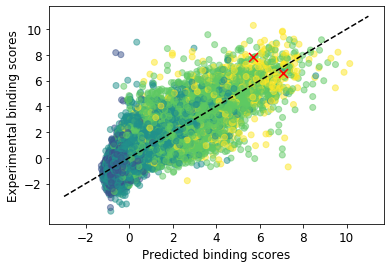

In [76]:
fig = plt.figure()
plt.plot([-3,11], [-3,11], '--k')
plt.scatter(predictions[:,0], test['targets'][:,0], c=max_scan, cmap='viridis', alpha=0.5, rasterized=True)
plt.scatter(predictions[index,0], test['targets'][index,0], marker='x', c='r', s=80)
plt.xlabel('Predicted binding scores', fontsize=12)
plt.ylabel('Experimental binding scores', fontsize=12)
plt.xticks([-2, 0, 2, 4, 6, 8, 10], fontsize=12)
plt.yticks([-2, 0, 2, 4, 6, 8, 10], fontsize=12)
outfile = os.path.join(plot_path, 'rbfox1_scatter.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

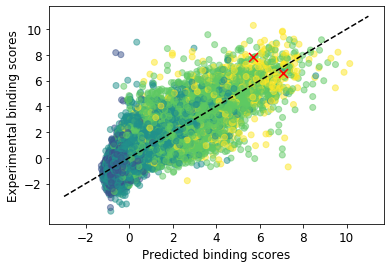

In [8]:
fig = plt.figure()
plt.plot([-3,11], [-3,11], '--k')
plt.scatter(predictions[:,0], test['targets'][:,0], c=max_scan, cmap='viridis', alpha=0.5)
plt.scatter(predictions[index,0], test['targets'][index,0], marker='x', c='r', s=80)
plt.xlabel('Predicted binding scores', fontsize=12)
plt.ylabel('Experimental binding scores', fontsize=12)
plt.xticks([-2, 0, 2, 4, 6, 8, 10], fontsize=12)
plt.yticks([-2, 0, 2, 4, 6, 8, 10], fontsize=12)
outfile = os.path.join(plot_path, 'rbfox1_scatter_hires.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

# Plot mutagenesis logo

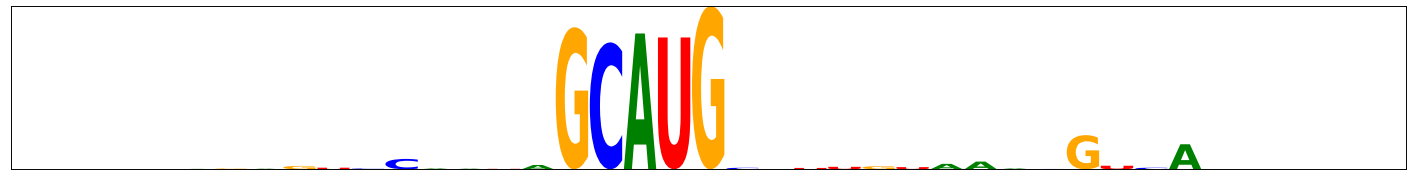

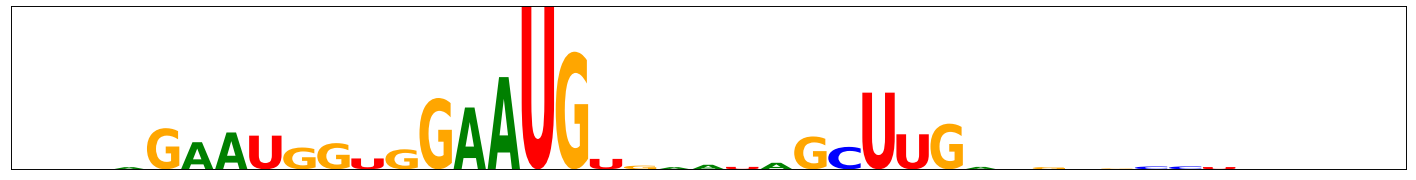

In [77]:
N, L, A = X.shape
for k in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = scores[k,l,a]

    fig = plt.figure(figsize=(25,3))
    ax = plt.subplot(1,1,1)
    logomaker.Logo(counts_df, ax=ax)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    fig = plt.gcf()
    ax2 = ax.twinx()
    #plt.title(index[k], fontsize=16)
    #plt.ylabel(np.round(pr_score[k],4), fontsize=16)
    plt.yticks([])
    outfile = os.path.join(plot_path, str(index[k])+'_rbfox1_saliency.pdf')
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    

# GIA for multiple binding sites

In [78]:
from residualbind import GlobalImportance
alphabet = 'ACGU'

# instantiate global importance
gi = GlobalImportance(model, alphabet)

# set null sequence model
null_seq_model = np.mean(np.squeeze(train['inputs']), axis=0)
null_seq_model /= np.sum(null_seq_model, axis=1, keepdims=True)
gi.set_null_model(null_seq_model, num_sim=1000)

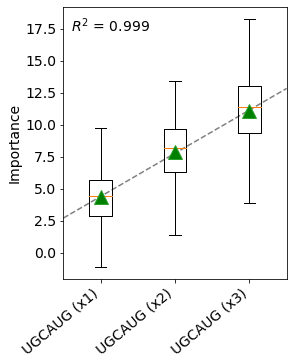

In [79]:
# GIA for optimal binding site
motif = 'UGCAUG'
positions = [4, 12, 20]
all_scores = gi.multiple_sites(motif, positions, class_index=0)

fig = plt.figure(figsize=(4,5))
flierprops = dict(marker='^', markerfacecolor='green', markersize=14,linestyle='none')
box = plt.boxplot(all_scores.T, showfliers=False, showmeans=True, meanprops=flierprops);
plt.xticks(range(1,len(positions)+1), [motif+' (x1)', motif+' (x2)', motif+' (x3)'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
plt.setp(ax.get_yticklabels(),fontsize=14)
plt.ylabel('Importance', fontsize=14);
x = np.linspace(1,3,3)
p = np.polyfit(x, np.mean(all_scores, axis=1), 1)
determination = np.corrcoef(x, np.mean(all_scores, axis=1))[0,1]**2
x = np.linspace(0.5,3.5,10)
plt.plot(x, x*p[0] + p[1], '--k', alpha=0.5)
MAX = 0
for w in box['whiskers']:
    MAX = np.maximum(MAX, np.max(w.get_ydata()))
scale = (np.percentile(all_scores, 90) - np.percentile(all_scores,10))/10
plt.text(0.6, MAX-scale, "$R^2$ = %.3f"%(determination), fontsize=14)

outfile = os.path.join(plot_path, 'rbfox1_multiple_binding_sites.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

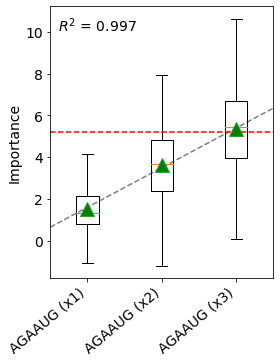

In [80]:
# GIA for sub-optimal binding site
motif = 'AGAAUG'
positions = [4, 12, 20]
all_scores = gi.multiple_sites(motif, positions, class_index=0)

fig = plt.figure(figsize=(4,5))
flierprops = dict(marker='^', markerfacecolor='green', markersize=14,linestyle='none')
box = plt.boxplot(all_scores.T, showfliers=False, showmeans=True, meanprops=flierprops);
plt.xticks(range(1,len(positions)+1), [motif+' (x1)', motif+' (x2)', motif+' (x3)'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
plt.setp(ax.get_yticklabels(),fontsize=14)
plt.ylabel('Importance', fontsize=14);
x = np.linspace(1,3,3)
p = np.polyfit(x, np.mean(all_scores, axis=1), 1)
determination = np.corrcoef(x, np.mean(all_scores, axis=1))[0,1]**2
x = np.linspace(0.5,3.5,10)
plt.plot(x, x*p[0] + p[1], '--k', alpha=0.5)
MAX = 0
for w in box['whiskers']:
    MAX = np.maximum(MAX, np.max(w.get_ydata()))
scale = (np.percentile(all_scores, 90) - np.percentile(all_scores,10))/10
plt.text(0.6, MAX-scale, "$R^2$ = %.3f"%(determination), fontsize=14)

plt.plot([0.5,3.5],[5.18859, 5.18859], '--r')

outfile = os.path.join(plot_path, 'rbfox1_mutated_multiple_binding_sites.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

# GIA for motif spacing

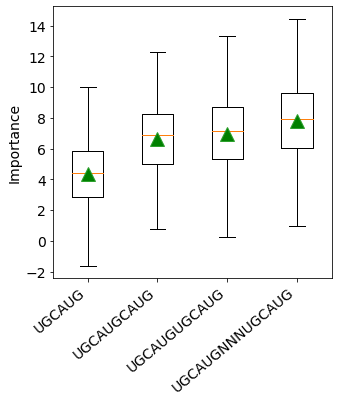

In [128]:

from residualbind import GlobalImportance
alphabet = 'ACGU'

class_index = 0

# instantiate global importance
gi = GlobalImportance(model, alphabet)

# set null sequence model
null_seq_model = np.mean(np.squeeze(train['inputs']), axis=0)
null_seq_model /= np.sum(null_seq_model, axis=1, keepdims=True)
gi.set_null_model(null_seq_model, num_sim=1000)


names = ['UGCAUG', 'UGCAUGCAUG', 'UGCAUGUGCAUG', 'UGCAUGNNNUGCAUG']
motif = 'UGCAUG'
positions = [[17,17], [16, 20], [15, 21], [13, 22]]
all_scores = []
for position in positions:
    interventions = []
    for pos in position:
        interventions.append((motif, pos))
    all_scores.append(gi.embed_predict_effect(interventions, class_index))
all_scores = np.array(all_scores)

fig = plt.figure(figsize=(5,5))
flierprops = dict(marker='^', markerfacecolor='green', markersize=14,linestyle='none')
box = plt.boxplot(all_scores.T, showfliers=False, showmeans=True, meanprops=flierprops);
plt.xticks(range(1,len(positions)+1), names, rotation=40, fontsize=14, ha='right');
ax = plt.gca();
plt.setp(ax.get_yticklabels(),fontsize=14)
plt.ylabel('Importance', fontsize=14);

outfile = os.path.join(plot_path, 'rbfox1_separation.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

# Compare to Experimental KD measurements

In [82]:

from residualbind import GlobalImportance
alphabet = 'ACGU'

class_index = 0

# instantiate global importance
gi = GlobalImportance(model, alphabet)

# set null sequence model
null_seq_model = np.mean(np.squeeze(train['inputs']), axis=0)
null_seq_model /= np.sum(null_seq_model, axis=1, keepdims=True)
gi.set_null_model(null_seq_model, num_sim=1000)


In [83]:
# measurements from Auweter et al. "Molecular basis of RNA recognition by the
# human alternative splicing factor Fox-1" EMBO 2006
patterns = ['UGCAUGU', 'AGCAUGU', 'CGCAUGU', 'UGUAUGU', 'UACAUGU', 'UGCACGU', 'UGCAUAU']
exp_scores = np.array([0.83, 4.8, 6.1, 280, 350, 4.9, 1830])

# GIA analysis for same mutations with experimental measurements
position = 17
class_index = 0

all_scores = []
for pattern in patterns:
    scores = gi.embed_predict_effect((pattern, position), class_index)
    all_scores.append(np.mean(scores))
all_scores = np.array(all_scores)

In [84]:
# perform linear regression and get statistics
from scipy import stats
results = stats.linregress(all_scores, np.log(exp_scores))
results

LinregressResult(slope=-1.5994982872080745, intercept=6.52780275775905, rvalue=-0.941559172233734, pvalue=0.0015364226421229583, stderr=0.2559084660508973)

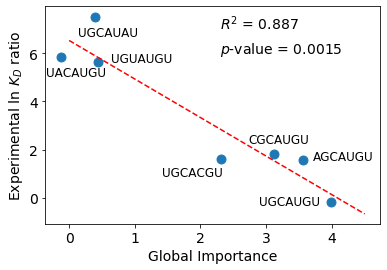

In [125]:

fig = plt.figure(figsize=(6,4))
plt.scatter(all_scores, np.log(exp_scores), s=80)
p = np.polyfit(all_scores, np.log(exp_scores), 1)
x = np.linspace(0,4.5,20)
y = results.slope*x + results.intercept
plt.plot(x,y,'--r')
plt.text(2.3, 7, '$R^2$ = %.3f'%(results.rvalue**2), fontsize=14)
plt.text(2.3, 6, '$p$-value = %.4f'%(results.pvalue), fontsize=14)
ax = plt.gca();
plt.setp(ax.get_yticklabels(),fontsize=14)
plt.setp(ax.get_xticklabels(),fontsize=14)
plt.ylabel('Experimental $\ln~{K_D}$ ratio', fontsize=14);
plt.xlabel('Global Importance', fontsize=14);

#exp_scores = np.array([0.83, 4.8, 6.1, 280, 350, 4.9, 1830])

plt.text(all_scores[0]-1.1, np.log(exp_scores[0])+-.1, 'UGCAUGU', fontsize=12)
plt.text(all_scores[1]+.15, np.log(exp_scores[1])+.0, 'AGCAUGU', fontsize=12)

plt.text(all_scores[2]-.4, np.log(exp_scores[2])+.45, 'CGCAUGU', fontsize=12)

plt.text(all_scores[5]-.9, np.log(exp_scores[5])-.7, 'UGCACGU', fontsize=12)
plt.text(all_scores[3]+.2, np.log(exp_scores[3])-0, 'UGUAUGU', fontsize=12)
plt.text(all_scores[4]-.23, np.log(exp_scores[4])-.8, 'UACAUGU', fontsize=12)
plt.text(all_scores[6]-.25, np.log(exp_scores[6])-.8, 'UGCAUAU', fontsize=12)

    
outfile = os.path.join(plot_path, 'rbfox1_GIA_vs_experimentalKD.pdf')
fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')